<a href="https://colab.research.google.com/github/jdasam/mas1004-2023/blob/main/live_coding/5_collobrative_filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Import Library and Download data

In [1]:
!wget https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
!unzip ml-latest-small.zip

--2023-11-16 05:50:28--  https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K  3.08MB/s    in 0.3s    

2023-11-16 05:50:29 (3.08 MB/s) - ‘ml-latest-small.zip’ saved [978202/978202]

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


### Import libraries and functions

In [2]:
from tqdm.auto import tqdm
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

class RatingSet:
  def __init__(self, csv_path='ml-latest-small/ratings.csv'):
    self.ratings = pd.read_csv(csv_path)

    # how many unique users exist in this dataset
    self.n_users = len(set(self.ratings['userId']))
    self.n_movies = len(set(self.ratings['movieId']))

    # list the every ids of included users
    self.user_ids = list(set(self.ratings['userId']))
    self.movie_ids = sorted(list(set(self.ratings['movieId'])))

    # we have to find in which idx the given movieId exists in this dataset's movie ID
    self.movie2idx = {id: idx for idx, id in enumerate(self.movie_ids)}
    self.user2idx = {id: idx for idx, id in enumerate(self.user_ids)}

  def __len__(self): # how many data sample exists in the dataset
    return len(self.ratings) # number of ratings in the dataset

  def __getitem__(self, idx): # get the idx-th sample from the dataset
    idx_row = self.ratings.iloc[idx]

    user_id = self.user2idx[idx_row.userId]
    movie_id = self.movie2idx[idx_row.movieId]
    rating = idx_row.rating

    return user_id, movie_id, torch.tensor(rating, dtype=torch.float32)

class MatrixFactorizer(nn.Module):
  def __init__(self, n_user, n_movie, n_factor):
    super().__init__()

    self.user_embedding = nn.Embedding(n_user, n_factor)
    self.movie_embedding = nn.Embedding(n_movie, n_factor)

    self.user_embedding.weight.data /= n_factor
    self.movie_embedding.weight.data /= n_factor

    self.scale = 5.5

  def scaled_sigmoid(self, x):
    return 1/(1+torch.exp(-x/self.scale)) * self.scale

  def forward(self, user_id, movie_id):
    user_emb_vec = self.user_embedding(user_id)
    movie_emb_vec = self.movie_embedding(movie_id)

    elem_wise_multiplication_result = user_emb_vec * movie_emb_vec
    dot_prod_result = elem_wise_multiplication_result.sum(dim=1)

    return self.scaled_sigmoid(dot_prod_result)



class MatrixFactorizerWithBias(MatrixFactorizer):
  def __init__(self, n_user, n_movie, n_factor):
    super().__init__(n_user, n_movie, n_factor)
    self.user_bias = nn.Embedding(n_user, 1)
    self.movie_bias = nn.Embedding(n_movie, 1)
    self.user_bias.weight.data = torch.zeros(n_user, 1)
    self.movie_bias.weight.data = torch.zeros(n_movie, 1)


  def forward(self, user_id, movie_id):
    user_emb_vec = self.user_embedding(user_id)
    movie_emb_vec = self.movie_embedding(movie_id)

    elem_wise_multiplication_result = user_emb_vec * movie_emb_vec
    dot_prod_result = elem_wise_multiplication_result.sum(dim=1)
    dot_prod_result += self.user_bias(user_id)[:, 0] + self.movie_bias(movie_id)[:, 0]

    return self.scaled_sigmoid(dot_prod_result)

class Trainer:
  def __init__(self, model, train_loader, valid_loader, model_name='movielens', device='cpu'):
    self.model = model
    self.train_loader = train_loader
    self.valid_loader = valid_loader
    self.device = device
    self.model.to(self.device)
    self.criterion = nn.MSELoss()
    self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
    self.acc_threshold = 0.5
    self.best_loss = torch.inf
    self.best_acc = 0.0
    self.train_losses = []
    self.valid_losses = []
    self.train_accs = []
    self.valid_accs = []
    self.model_name = model_name

  def validation(self):
    self.model.eval() # change the model from train mode to evaluation mode
    # Some models work in different ways based on whtehter it is on training step
    # or on inference step

    # In validation step, you don't have to calculate the gradient
    # with torch.no_grad():

    current_loss = 0
    num_total_correct_pred = 0
    with torch.inference_mode(): # every torch computation under this indent
    # will be run without calculating the gradient or computation history
      for batch in self.valid_loader:
        user_ids, movie_ids, ratings = batch
        user_ids, movie_ids, ratings = user_ids.to(self.device), movie_ids.to(self.device), ratings.to(self.device)

        self.optimizer.zero_grad()
        outputs = self.model(user_ids, movie_ids)

        loss = self.criterion(outputs, ratings) # you have to feed log_probs

        num_acc_pred = (torch.abs(outputs - ratings) < self.acc_threshold).sum()

        num_total_correct_pred += num_acc_pred.item()
        # in validation stage, we don't care about single batch's loss
        # we want to see the result for total images of validation set

        current_loss += loss.item() * len(ratings)
        # instead of adding the mean loss, we add sum of loss
        # because the batch size can be different
    mean_loss = current_loss / len(self.valid_loader.dataset)
    mean_acc = num_total_correct_pred / len(self.valid_loader.dataset) # number of total datasample in the validation loader
    return mean_loss, mean_acc
    # return {'loss': mean_loss, 'acc': mean_acc}



  def train_by_number_of_epochs(self, num_epochs):
    for epoch in tqdm(range(num_epochs)):
      self.model.train()
      for batch in tqdm(self.train_loader, leave=False):
        user_ids, movie_ids, ratings = batch
        user_ids, movie_ids, ratings = user_ids.to(self.device), movie_ids.to(self.device), ratings.to(self.device)
        self.optimizer.zero_grad()
        outputs = self.model(user_ids, movie_ids)

        loss = self.criterion(outputs, ratings) # you have to feed log_probs

        acc = (torch.abs(outputs - ratings) < self.acc_threshold).sum() / len(ratings)
        # for torch.nn.NLLLoss
        loss.backward()
        self.optimizer.step()

        self.train_losses.append(loss.item())
        self.train_accs.append(acc.item())
        # don't try self.train_losses.append(loss)
      # training step has ended
      # we want to test our model on the validation set
      valid_loss, valid_acc = self.validation()

      # is this model the best?
      # let's decide it based on valid_acc
      if valid_acc > self.best_acc:
        self.best_acc = valid_acc

        # If it is the best model, save the model's weight'
        models_parameters = self.model.state_dict()
        print(f"Saving best model at epoch {len(self.valid_accs)}, acc: {valid_acc}")
        torch.save(models_parameters, f'{self.model_name}_best.pt')

      self.valid_losses.append(valid_loss)
      self.valid_accs.append(valid_acc)

    # Plot Accuracy curve
    plt.plot(self.train_accs)
    plt.plot(range(len(self.train_loader)-1, len(self.train_accs), len(self.train_loader)) ,self.valid_accs)
    plt.title("Accuracy")

## Prepare Data Split and DataLoader

In [3]:
movies = pd.read_csv('ml-latest-small/movies.csv')
ratings = pd.read_csv('ml-latest-small/ratings.csv')

movies = movies[movies['movieId'].isin(ratings['movieId'])]
movies.reset_index(drop=True, inplace=True)
movies['title'].to_csv("list_of_movie_titles.csv")

dataset = RatingSet()
num_train = int(len(dataset)*0.9) # 90% is used for the training
num_valid = int(len(dataset)*0.05) # 5% is used for the validation
num_test = len(dataset) - num_train - num_valid # the remaining is used for the test
# num_test = int(len(dataset)*0.05)

train_set, valid_set, test_set = torch.utils.data.random_split(dataset,
                                              [num_train, num_valid, num_test],
                                               generator=torch.Generator().manual_seed(0))
# randomly split the dataset into train/valid/test


train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True, num_workers=2)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=512, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=512, shuffle=False)

In [4]:
# ratings['userId'] # ratings has 100836 ratings
len(set(ratings['userId'].values)) # How many unique users exists?: 610 unique users
# How many unique movies exists?
len(set(ratings['movieId'].values))  # How many unique movie exists?: 9724 unique movies
# Are the movies rated in equal numbers?

from collections import Counter
movie_counter = Counter(ratings['movieId'].values)
movie_counter.most_common(10)

[(356, 329),
 (318, 317),
 (296, 307),
 (593, 279),
 (2571, 278),
 (260, 251),
 (480, 238),
 (110, 237),
 (589, 224),
 (527, 220)]

In [5]:
dataset.movie2idx[362] #movieId to uniqueId
# movieId 362 is 320th movie in our dataset


320

In [6]:
ratings

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [7]:
dataset[1000]

(6, 5791, tensor(3.5000))

In [8]:
train_batch = next(iter(train_loader))
# train_batch
user, item, rating = train_batch

In [9]:
user

tensor([ 83, 598, 245, 199, 216, 598, 266, 286, 238,   5, 468, 607, 598, 143,
        316,  16, 159, 339, 578, 606, 103, 473, 211, 285, 598,  63, 392, 104,
         99, 433, 488, 200,  79, 609, 353, 301,  83,  50, 605,   5, 369, 559,
         92,  90, 380,  88, 108, 599, 468, 200, 304, 554, 365,  27, 181, 356,
        118,  33, 379, 605,   3, 264, 351, 304])

In [12]:
class MatrixFactorizer(nn.Module):
  def __init__(self, n_users, n_items, emb_size=32):
    super().__init__()
    self.user_embedding = nn.Embedding(n_users, emb_size)
    self.movie_embedding = nn.Embedding(n_items, emb_size)

  def forward(self, user, item):
    # user: torch.LongTensor of shape [BatchSize]
    # item: torch.LongTensor of shape [BatchSize]
    user_embs = self.user_embedding(user)
    item_embs = self.movie_embedding(item)
    ratings = (user_embs * item_embs).sum(dim=1)
    return ratings

model = MatrixFactorizer(dataset.n_users, dataset.n_movies)
estimated_ratings = model(user, item)

loss = ((estimated_ratings - rating) ** 2).mean()
loss

tensor(40.8685, grad_fn=<MeanBackward0>)

In [14]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=256, shuffle=True, num_workers=2)
DEV = 'cuda'
model = MatrixFactorizer(dataset.n_users, dataset.n_movies)
model.to(DEV)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 3

loss_record = []

for epoch in tqdm(range(num_epochs)):
  for batch in tqdm(train_loader, leave=False):
    user, item, rating = batch
    estimated_ratings = model(user.to(DEV), item.to(DEV))
    loss = ((estimated_ratings - rating.to(DEV)) ** 2).mean()
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    loss_record.append(loss.item())

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/355 [00:00<?, ?it/s]

  0%|          | 0/355 [00:00<?, ?it/s]

  0%|          | 0/355 [00:00<?, ?it/s]

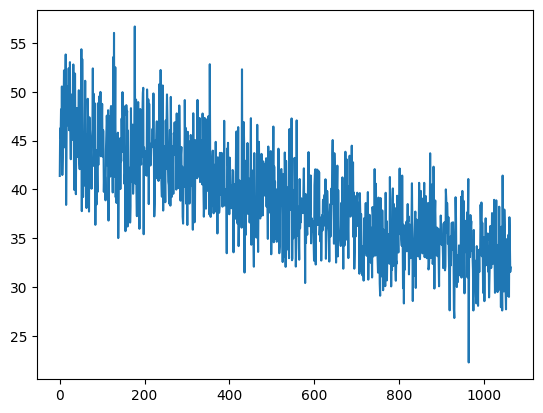

In [15]:
plt.plot(loss_record)